In [5]:
# Author: Robert Guthrie
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import sys
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import pylab as plt
import matplotlib as mpl
from sklearn import datasets
from collections import defaultdict
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
%matplotlib inline

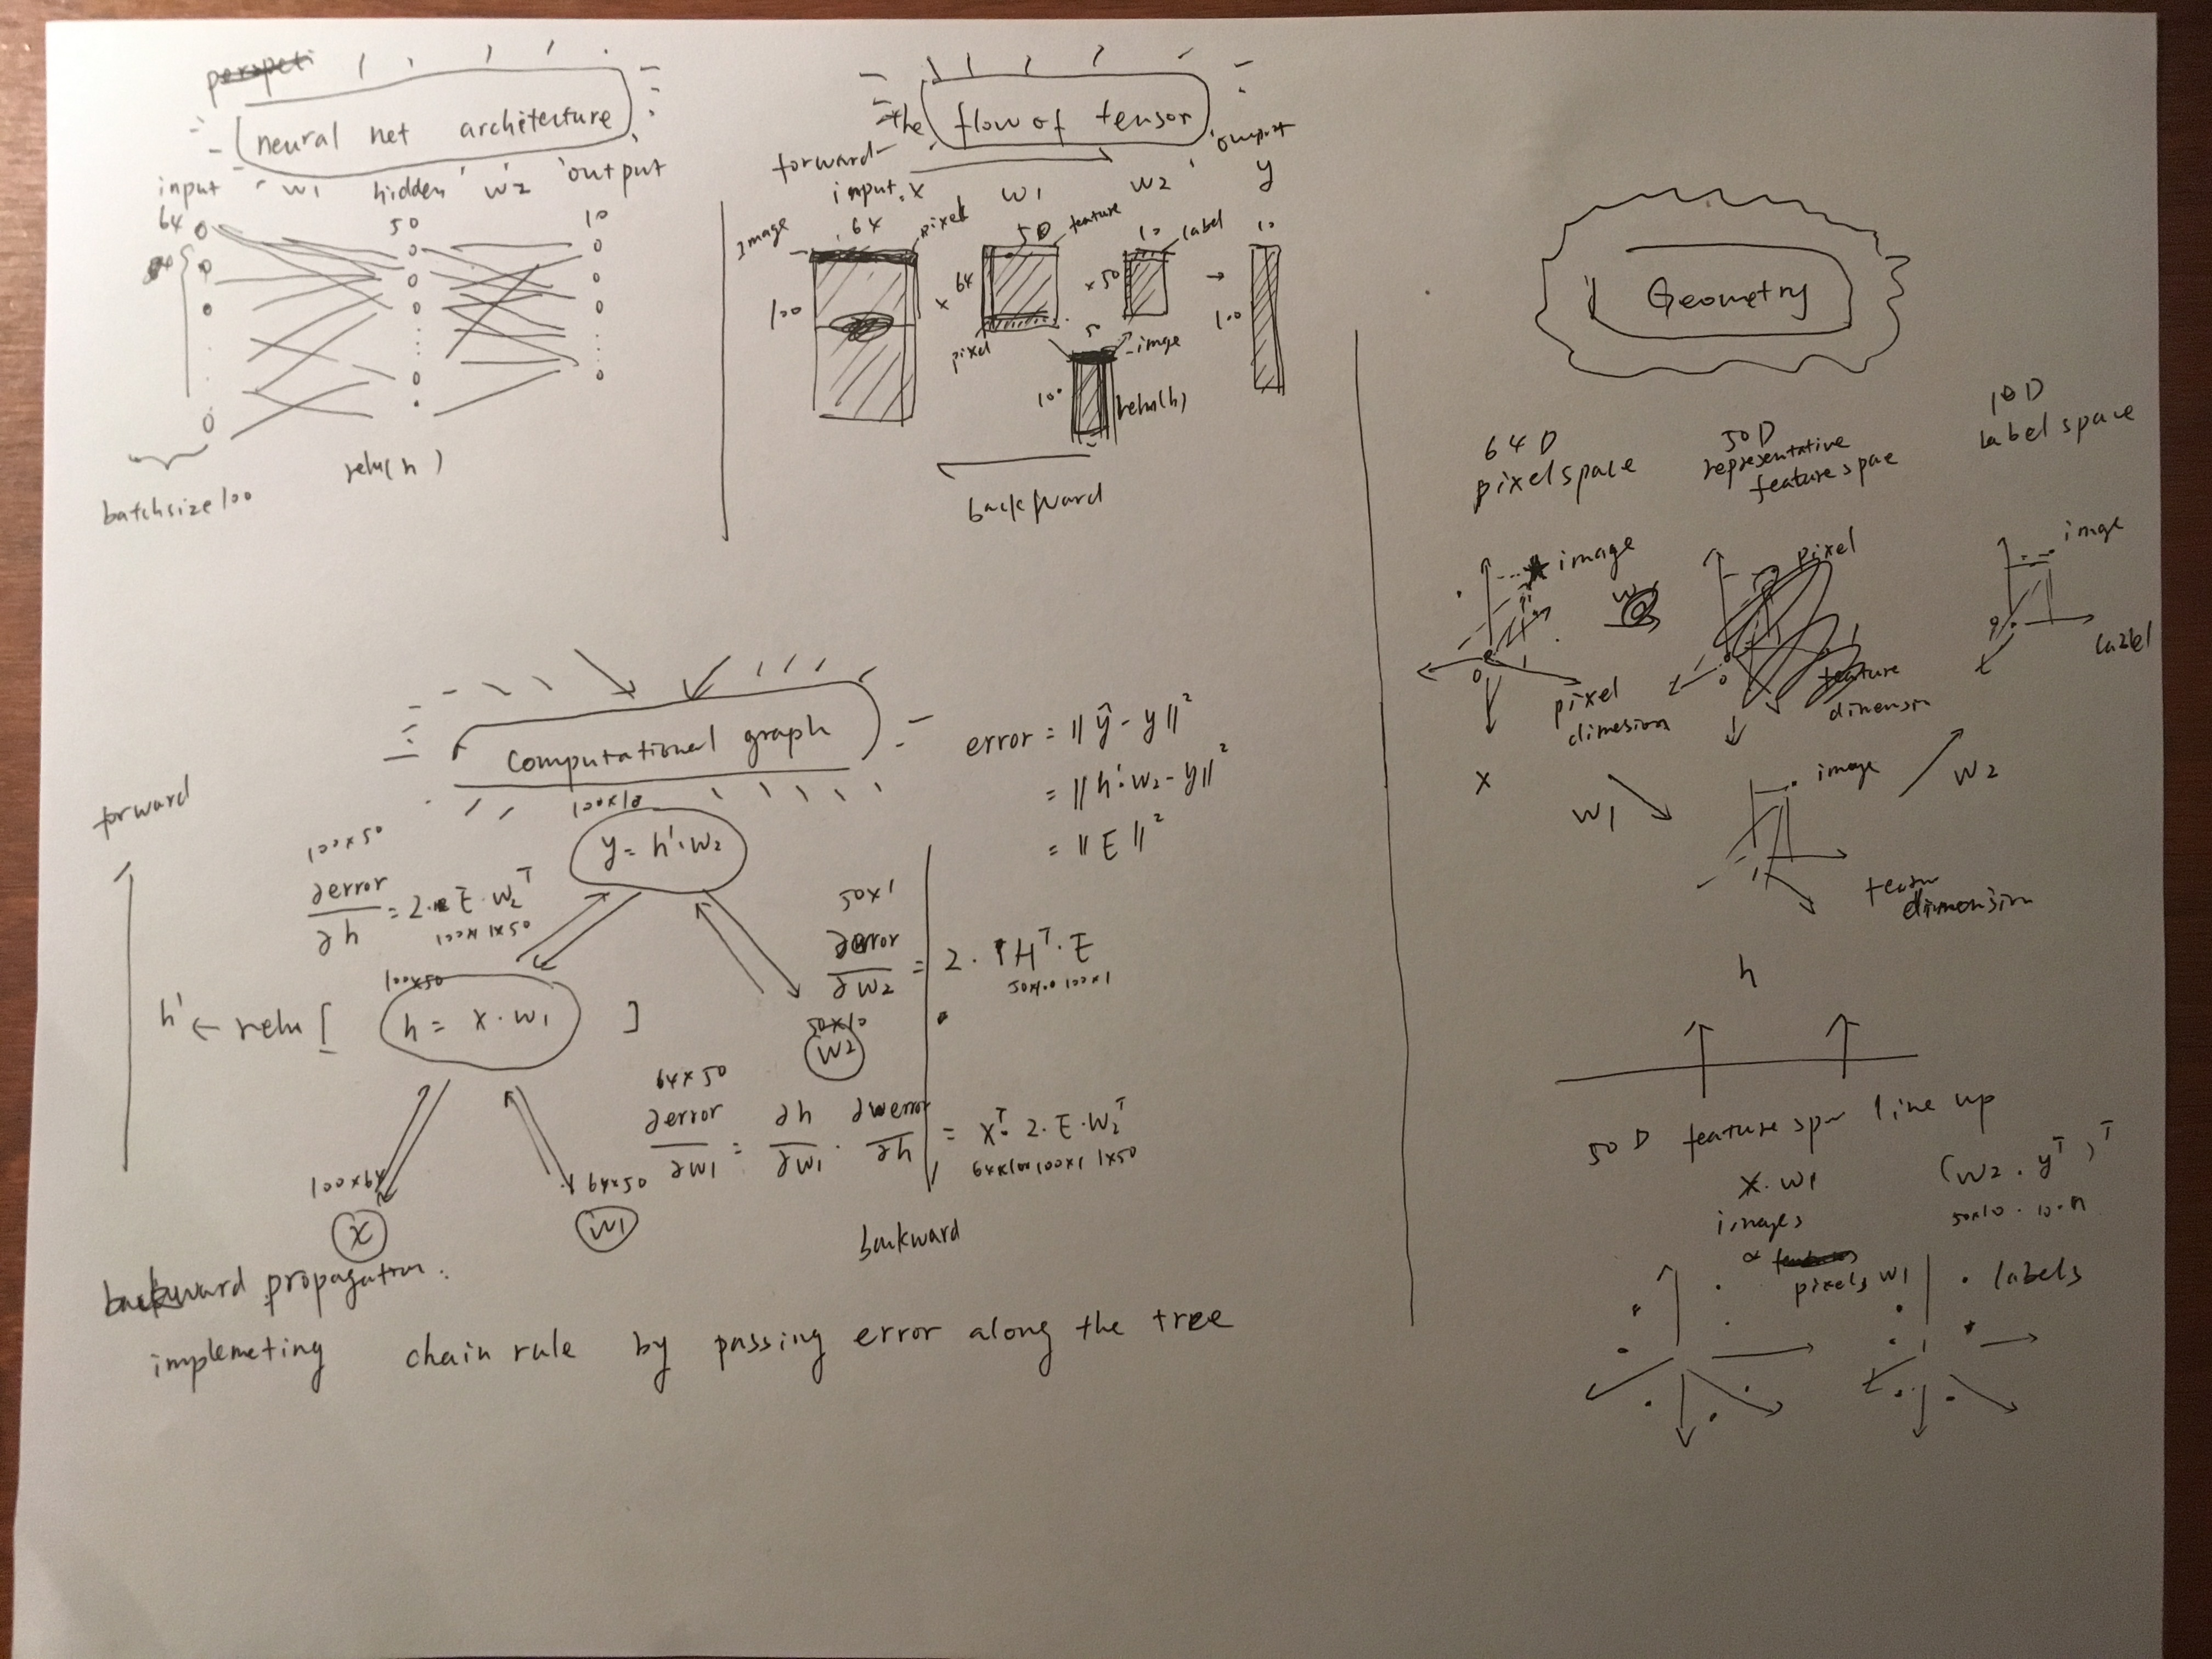

In [7]:
from IPython.display import Image
Image(filename = "/Users/lingfeiw/Desktop/map.jpeg", width=800)

# 1. Loading data 

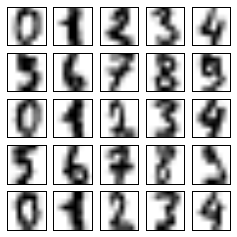

In [2]:
#basic functions
# softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def softmaxByRow(x):
    e_x = np.exp(x - x.max(axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()

# load data
digits = datasets.load_digits()
# display data
fig, ax = plt.subplots(5, 5, figsize=(4, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='binary')
    axi.set(xticks=[], yticks=[])

# 2. Neural Network (using numpy)

In [6]:
# prepare training sets
N,  H, D_in, D_out = 100, 30, 64, 10 # batch size, hidden, input, output dimension
k=0.9# the fraction traning data
N
learning_rate = 1e-6
L=len(digits.data)
l=int(L*k)
Batches={}
for j in range(N):
    index=list(np.random.randint(l, size=N))#randomly sample N data points
    y = np.zeros((N, 10))
    y[np.arange(N), list(digits.target[index])] = 1
    x=digits.data[index]
    Batches[j]=[x,y]
Loss=defaultdict(lambda:[])
w1 = np.random.randn(D_in, H)/float(H) # Randomly initialize weights
w2 = np.random.randn(H, D_out)/float(H)
w1c = w1.copy() # for comprision in viz
w2c = w2.copy()

In [345]:
# traning 
for j in Batches:
    flushPrint(j)
    x,y=Batches[j]
    for t in range(500):# repeated use of the same batch
        # Forward
        h = x.dot(w1)
        h_relu = np.maximum(h, 0)
        y_pred = h_relu.dot(w2)
        y_predS=softmaxByRow(y_pred)
        # loss
        loss = np.square(y_predS - y).sum()
        Loss[j].append([t,loss])
        # Backprop 
        grad_y_pred = 2.0 * (y_predS - y)
        grad_w2 = h_relu.T.dot(grad_y_pred)
        grad_h_relu = grad_y_pred.dot(w2.T)
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0
        grad_w1 = x.T.dot(grad_h)
        # Update weights
        w1 -= learning_rate * grad_w1
        w2 -= learning_rate * grad_w2

99

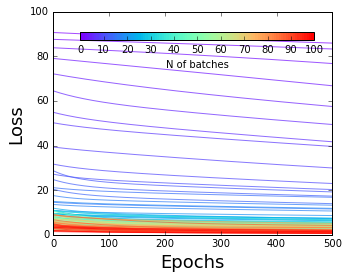

In [346]:
# Dispaly loss decreasing
fig = plt.figure(figsize=(5, 4))
cmap = cm.get_cmap('rainbow',Nbatch)
for i in Loss:
    epochs,loss=zip(*sorted(Loss[i]))
    plt.plot(epochs,loss,color=cmap(i),alpha=0.7)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
ax1 = fig.add_axes([0.2, 0.8, 0.65, 0.03])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=mpl.colors.Normalize(vmin=0, vmax=Nbatch),
                                orientation='horizontal')
cb1.set_label('N of batches')

In [347]:
# Test
TestData=digits.data[-(L-l):]
PredictData=np.maximum(TestData.dot(w1),0).dot(w2)
compare=np.argmax(PredictData,axis=1)-digits.target[-(L-l):]
Accuracy=list(compare).count(0)/float(len(compare))
Accuracy

0.9388888888888889

# 3. Visaulization

## 3.1 Matrices as manifold translators: before and after training

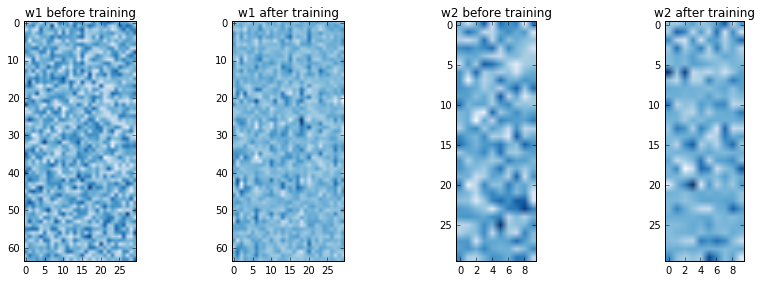

In [111]:
cmap=plt.cm.get_cmap('Accent', 10)
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(141)
plt.imshow(w1c,cmap='Blues')
plt.title('w1 before training')
fig.add_subplot(142)
plt.imshow(w1,cmap='Blues')
plt.title('w1 after training')
fig.add_subplot(143)
plt.imshow(w2c,cmap='Blues')
plt.title('w2 before training')
fig.add_subplot(144)
plt.imshow(w2,cmap='Blues')
plt.title('w2 after training')
plt.tight_layout()

In [250]:
projectionPixel = pca.fit_transform(w1)
projectionLabel = pca.fit_transform(w2.T)

## 3.2 Pixel manifold: what we see and what machine sees

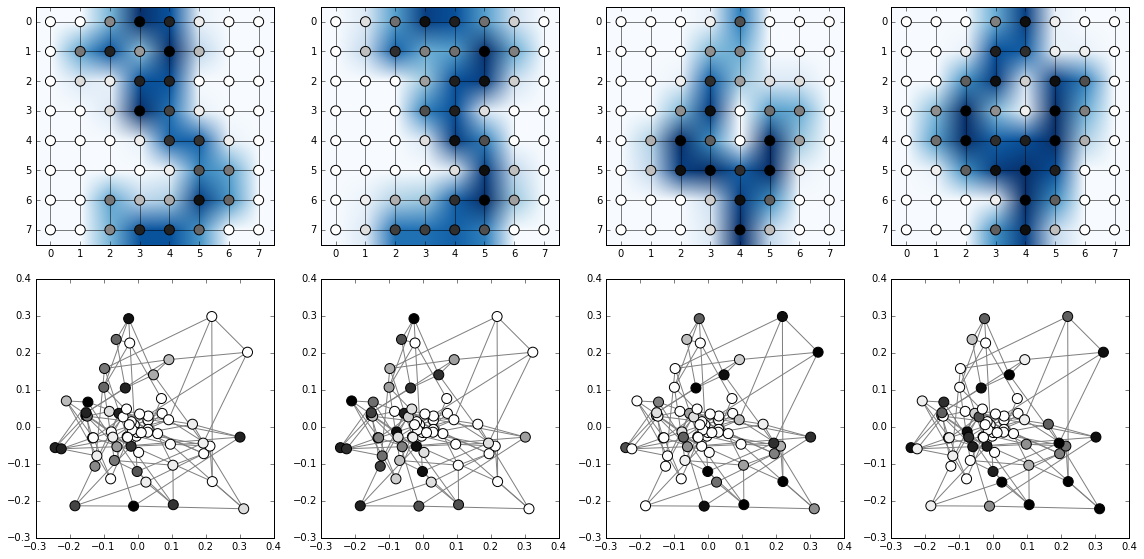

In [319]:
G=nx.grid_2d_graph(8,8)
pos=dict(((i,j),(i,j)) for i,j in G.nodes())
index=sorted(pos.keys())
posPixel=dict(zip(index,projectionPixel))
#
fig = plt.figure(figsize=(16, 8))
#
ax=fig.add_subplot(241)
data3_1=digits.images[3]
x,y,z=zip(*[(i,j,data3_1[i,j]) for i,j in index])
nx.draw_networkx_edges(G,pos=pos,color='gray',alpha=0.5)
plt.scatter(y,x,s=100,c=z,cmap='binary')
plt.imshow(data3_1,cmap='Blues')
#
ax=fig.add_subplot(245)
line_segments = LineCollection([[posPixel[i],posPixel[j]] for i,j in G.edges()],\
                               color='gray',zorder=1)
ax.add_collection(line_segments)
x,y,z=zip(*[(projectionPixel[n][0],projectionPixel[n][1],data3_1[xy[0],xy[1]]) \
            for n,xy in enumerate(index)])
plt.scatter(x,y,s=100,c=z,cmap='binary',zorder=2)
#
ax=fig.add_subplot(242)
data3_2=digits.images[13]
x,y,z=zip(*[(i,j,data3_2[i,j]) for i,j in index])
nx.draw_networkx_edges(G,pos=pos,color='gray',alpha=0.5)
plt.scatter(y,x,s=100,c=z,cmap='binary')
plt.imshow(data3_2,cmap='Blues')
#
ax=fig.add_subplot(246)
line_segments = LineCollection([[posPixel[i],posPixel[j]] for i,j in G.edges()],\
                               color='gray',zorder=1)
ax.add_collection(line_segments)
x,y,z=zip(*[(projectionPixel[n][0],projectionPixel[n][1],data3_2[xy[0],xy[1]]) \
            for n,xy in enumerate(index)])
plt.scatter(x,y,s=100,c=z,cmap='binary',zorder=2)
#
ax=fig.add_subplot(243)
data4_1=digits.images[4]
x,y,z=zip(*[(i,j,data4_1[i,j]) for i,j in index])
nx.draw_networkx_edges(G,pos=pos,color='gray',alpha=0.5)
plt.scatter(y,x,s=100,c=z,cmap='binary')
plt.imshow(data4_1,cmap='Blues')
#
#
ax=fig.add_subplot(247)
line_segments = LineCollection([[posPixel[i],posPixel[j]] for i,j in G.edges()],\
                               color='gray',zorder=1)
ax.add_collection(line_segments)
x,y,z=zip(*[(projectionPixel[n][0],projectionPixel[n][1],data4_1[xy[0],xy[1]]) \
            for n,xy in enumerate(index)])
plt.scatter(x,y,s=100,c=z,cmap='binary',zorder=2)
#
ax=fig.add_subplot(244)
data4_2=digits.images[14]
x,y,z=zip(*[(i,j,data4_2[i,j]) for i,j in index])
nx.draw_networkx_edges(G,pos=pos,color='gray',alpha=0.5)
plt.scatter(y,x,s=100,c=z,cmap='binary')
plt.imshow(data4_2,cmap='Blues')
#
#
ax=fig.add_subplot(248)
line_segments = LineCollection([[posPixel[i],posPixel[j]] for i,j in G.edges()],\
                               color='gray',zorder=1)
ax.add_collection(line_segments)
x,y,z=zip(*[(projectionPixel[n][0],projectionPixel[n][1],data4_2[xy[0],xy[1]]) \
            for n,xy in enumerate(index)])
plt.scatter(x,y,s=100,c=z,cmap='binary',zorder=2)
#
plt.tight_layout()
plt.show()

In [113]:
# dimension reduction for viz
pca = PCA(n_components=2)
iso = Isomap(n_components=2)
tsne = TSNE(n_components=2)
mds = MDS(n_components=2)
#
encodeData = digits.data.dot(w1)
projection0 = pca.fit_transform(digits.data)
projection1 = pca.fit_transform(encodeData)
projection2 = mds.fit_transform(digits.data)
projection3 = iso.fit_transform(digits.data)
projection4 = tsne.fit_transform(digits.data)
#
targ = np.zeros((len(digits.target), 10))
targ[np.arange(len(digits.target)), list(digits.target)] = 1
encodeTarget = w2.dot(targ.T).T
projection11 = pca.fit_transform(encodeTarget)

## 3.3 Alternative manifold learning methods

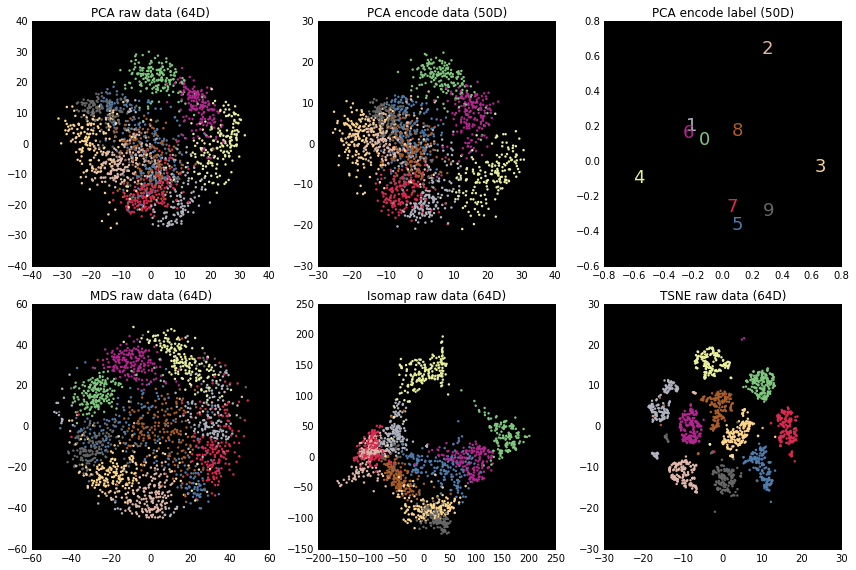

In [320]:
# viz
cmap=plt.cm.get_cmap('Accent', 10)
fig = plt.figure(figsize=(12, 8))
#
def viz(projection,ax,title):
    plt.scatter(projection[:, 0], projection[:, 1],lw=0,s=6,c=digits.target, cmap=cmap)
    #plt.colorbar(ticks=range(10), label='digit value')
    plt.title(title)
    ax.set_axis_bgcolor('black')    
#
ax=fig.add_subplot(233)
xs,ys=np.round(projection11,3).T
for x,y,i in set(zip(xs, ys,digits.target)):
    plt.scatter(x,y,alpha=0)
    plt.text(x,y,str(i),color=cmap(i),size=18)
ax.set_axis_bgcolor('black')
plt.title('PCA encode label (50D)')
#
viz(projection0,fig.add_subplot(231),'PCA raw data (64D)')
viz(projection1,fig.add_subplot(232),'PCA encode data (50D)')
#viz(projection11,fig.add_subplot(233),'PCA encode label (50D)')
viz(projection2,fig.add_subplot(234),'MDS raw data (64D)')
viz(projection3,fig.add_subplot(235),'Isomap raw data (64D)')
viz(projection4,fig.add_subplot(236),'TSNE raw data (64D)')
#
plt.tight_layout()

# 4. Neural Network (using PyTorch)

In [350]:
# initialize
dtype = torch.FloatTensor
w1 = Variable(torch.randn(D_in, H).type(dtype)/float(H), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype)/float(H), requires_grad=True)
learning_rate = 1e-6
Loss=defaultdict(lambda:[])

In [351]:
# train
for j in Batches:
    flushPrint(j)
    x,y=Batches[j]
    x = Variable(torch.from_numpy(x).type(dtype), requires_grad=False)  
    y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
    for t in range(500):
        y_pred = x.mm(w1).clamp(min=0).mm(w2)
        softmax = nn.Softmax()
        y_soft=softmax(y_pred)
        loss = (y_soft - y).pow(2).sum()
        Loss[j].append([t,loss.data[0]])
        loss.backward()
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()

0

/Users/lingfeiw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


99

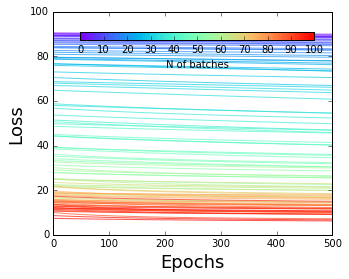

In [352]:
# Dispaly loss decreasing
fig = plt.figure(figsize=(5, 4))
cmap = cm.get_cmap('rainbow',Nbatch)
for i in Loss:
    epochs,loss=zip(*sorted(Loss[i]))
    plt.plot(epochs,loss,color=cmap(i),alpha=0.7)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
ax1 = fig.add_axes([0.2, 0.8, 0.65, 0.03])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=mpl.colors.Normalize(vmin=0, vmax=Nbatch),
                                orientation='horizontal')
cb1.set_label('N of batches')

In [353]:

TestData=digits.data[-(L-l):]
xTest = Variable(torch.from_numpy(TestData).type(dtype), requires_grad=False)
PredictData = xTest.mm(w1).clamp(min=0).mm(w2)
compare=np.argmax(PredictData.data.numpy(),axis=1)-digits.target[-(L-l):]
Accuracy=list(compare).count(0)/float(len(compare))
Accuracy

0.9222222222222223